### **Welcome to the TSI-Toolkit!**
The **goal of this tutorial** is to familiarize the user with using tsi-toolkit to import their time series data, to create and compare models that aim to capture the variablity in their data, and apply models to make predictions of the time series at new, previously unobserved data points, either in the future (forecasting) or between observed values (interpolation). 

This package was designed to be convenient and intuitive, regardless of your background in Python and machine learning. I deeply appreciate those who voice their frustrations, whether about bugs or how this package could better serve you. Please feel free to open a new issue post in the [Github Repo's Issue Page](https://github.com/collinlewin/tsi-toolkit/issues), or by emailing me, Collin Lewin (clewin@mit.edu).

##### *In this tutorial, we will learn how to...*
1. Importing, cleaning, and plotting time series data
2. The basics of modeling data with Gaussian processes (GPs)
3. How to train a GP using our data and select between GP models
4. Predicting values of the time series at new times (interpolation or forecasting)
5. Generate a slew of powerful products for gaining insight on the data.

In [ ]:
%load_ext autoreload
%autoreload 2

from tsi_toolkit.data_loader import TimeSeries
import numpy as np
import matplotlib.pyplot as plt

Removed 0 NaN points.
(0 NaN values, 0 NaN errors)
Removed 5 outliers (1.88% of data).


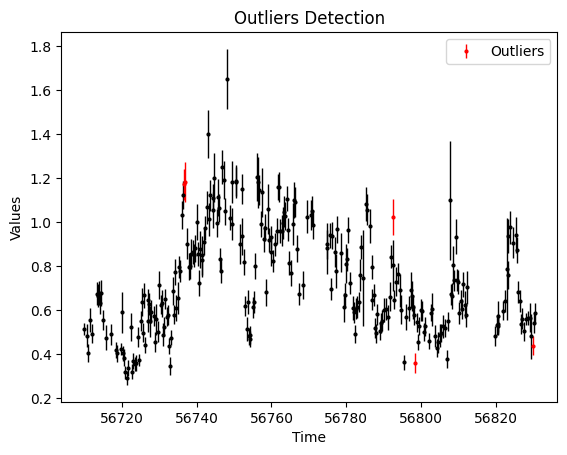

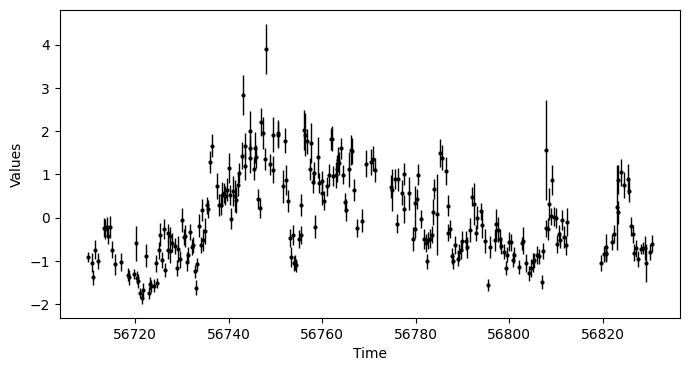

In [54]:
 ### Import data

# Import from file directly
file_path = '/home/clewin/projects/tsi-toolkit/data/'
lightcurve1 = TimeSeries(file_path = f'{file_path}NGC5548_U_swift.dat')

# Import from array
data = np.genfromtxt(f'{file_path}NGC5548_X_swift.dat')
lightcurve2 = TimeSeries(times=data[:,0], values=data[:,1], errors=data[:,2], clean_data=True, outlier_threshold=2,
                         outlier_rolling_window=20)
lightcurve2.plot()


# Plot takes in several common matplotlib arguments to add some flair
#lightcurve.plot()

# Plot with custom arguments
# the U-band is around 3500 angstroms, and ultraviolet, so let's make the plot violet
# # lightcurve.plot(figsize=(8,4),
# #                 xlabel='Modified Heliocentric Julian Date (Days)', 
# #                 ylabel='Flux',
# #                 xlim = (lightcurve.times[0], lightcurve.times[-1]),
# #                 title='NGC 5548 U-band Lightcurve',
# #                 fig_kwargs={'linewidth':28},
# #                 plot_kwargs={'color':'purple', 'fmt':'o', 'lw':1, 'ms':3},
# #                 major_tick_kwargs={'direction':'in', 'top':True, 'right':True, 'length':6, 'width':1},
# #                 minor_tick_kwargs={'direction':'in', 'top':True, 'right':True, 'length':3, 'width':0.5},
# #                 )

# lightcurve.unstandardize()